# ECONOMICS OF FINANCIAL MARKETS - CODE

In [70]:
#IMPORT NECESSARY LIBRIARIES
# Data manipulation and analysis libraries
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from scipy import optimize
from scipy.stats import kurtosis, skew, chisquare
# Portfolio optimization libraries
import riskfolio as rp
import pypfopt as py
# Plotting libraries
from pypfopt import plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#This is a function that computes the main statistics of the portfolios
def ptf_stats(x,r=False):
    if r==False:
        y=(returns*np.array(x).T).sum(axis=1)
    elif r==True:
        y=x
    print('Mean:',y.mean())
    print('STD:',y.std())
    print('Variance:',y.var())
    print('Skew:',y.skew())
    print('Kurtosis:',y.kurt())

In [5]:
# To run the monthly data, plug "monthly" instead of "daily" in the following two lines
#Be careful: we modified the initial excels file in order to speed up the uploading of the data
name_sheet='stocks daily'
x='daily'
mib_sheet='FTSEMIB' +x

data=pd.read_excel('C:/Users/gabri/Downloads/exam 2023/exam 2023/data for exam 2023.xlsx',sheet_name=name_sheet, index_col=0)
returns = (data / data.shift(1)) - 1
# drop Not Applicable values
returns=returns[~returns.isin([np.inf, -np.inf, np.nan]).all(axis='columns')].dropna()

# set the frequency
if name_sheet=='stocks monthly':
    t_freq=12
else:
    t_freq=252

## Security analysis

In [6]:
returns.tail()

,I:LDO,I:ECK,I:LRZ,I:PIRL,I:STL,I:PINF,I:BRE,I:ISP,I:ILLB,I:UCG,...,I:GAB,I:MS,I:ERG,I:CMB,I:SAB,I:BE,I:SOL,I:DAL,I:BSS,I:SAFI
Code,,,,,,,,,,,,,,,,,,,,,
2023-06-28,0.013780,0.053985,-0.012891,0.010112,0.010187,0.053528,0.015244,0.000847,-0.013365,-0.000486,...,0.045556,0.028364,0.015480,0.006849,0.000000,0.003861,0.021569,0.029630,0.001696,0.000000
2023-06-29,0.012621,0.004878,0.000000,0.000667,0.035553,-0.027714,0.007508,0.009520,0.007171,0.026738,...,-0.029756,0.005658,-0.008384,0.006803,0.000000,0.000000,-0.001919,-0.004317,0.001693,0.012914
2023-06-30,-0.003356,-0.024272,0.020522,0.005780,0.004370,0.002375,0.011923,0.005868,0.004747,0.006866,...,0.000000,-0.011955,0.036895,0.033784,0.020000,0.000000,0.017308,0.004335,0.019442,-0.010359
2023-07-03,0.004329,0.000000,-0.003656,0.008842,0.012554,0.026066,-0.003682,0.015417,0.001575,0.010581,...,0.006572,0.000712,0.001483,-0.019608,0.008403,-0.019231,-0.001890,-0.007914,-0.014925,0.002415
2023-07-04,-0.009579,-0.022388,-0.014679,0.001534,-0.002210,-0.020785,-0.004435,-0.006771,0.002358,-0.016752,...,-0.005441,0.035562,0.011843,-0.013333,-0.019444,0.019608,-0.003788,0.006526,-0.010101,-0.040161


In [7]:
# compute stats for all the securities
stats=pd.DataFrame(returns.mean())
stats.columns=['Mean']
stats['STD']=returns.std()
stats['Variance']=returns.var()
stats['Skew']=returns.skew()
stats['Kurtosis']=returns.kurt()
# Test whether a sample differs from a normal distribution.
#source https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
stats['p-value']=scipy.stats.normaltest(returns, axis=0, nan_policy='propagate')[1]
print((stats['p-value']<0.05).value_counts())
print(stats)

p-value
True    83
Name: count, dtype: int64
            Mean       STD  Variance      Skew   Kurtosis        p-value
I:LDO   0.000458  0.025004  0.000625  0.052659  11.343132   2.571311e-49
I:ECK   0.001684  0.030759  0.000946  2.200217  14.046817  7.375040e-137
I:LRZ  -0.000298  0.030082  0.000905  0.865584  11.678805   1.487726e-73
I:PIRL  0.000028  0.023760  0.000565 -0.052228   6.000976   1.846630e-33
I:STL   0.000694  0.023657  0.000560 -0.363301   6.868366   1.090532e-41
...          ...       ...       ...       ...        ...            ...
I:BE    0.000239  0.026592  0.000707  2.121840  12.000578  1.657447e-129
I:SOL   0.000901  0.016236  0.000264  0.209216   1.387875   2.844597e-10
I:DAL  -0.000726  0.026863  0.000722  0.914037   7.847665   1.632251e-65
I:BSS  -0.000007  0.029475  0.000869 -0.248433   7.201552   3.512850e-40
I:SAFI  0.001016  0.032535  0.001059  0.661356   9.276027   3.549568e-59

[83 rows x 6 columns]


In [8]:
#This is an example of how the code works, followed by the plot for a single stock.
LDOnorm = scipy.stats.normaltest(returns['I:LDO'])
LDOnorm.statistic

223.7645073415658

In [9]:
#This is the plot function we are going to use below to plot the normality test null distribution
def plot(ax):  # we'll re-use this
    ax.plot(stat_vals, pdf)
    ax.set_title("Normality Test Null Distribution")
    ax.set_xlabel("statistic")
    ax.set_ylabel("probability density")

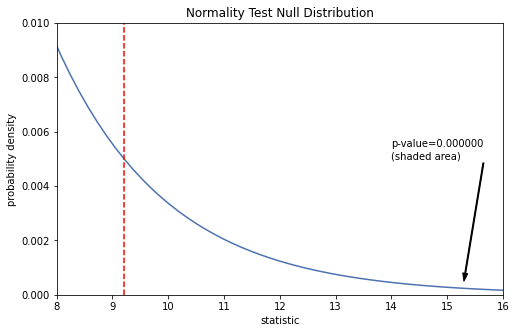

In [71]:
#Plot
dist = stats.chi2(df=2)
stat_vals = np.linspace(0, 16, 100)
pdf = dist.pdf(stat_vals)
fig, ax = plt.subplots(figsize=(8,5))
plot(ax)
pvalue = dist.sf(LDOnorm.statistic)
annotation = (f'p-value={pvalue:.6f}\n(shaded area)')
props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
_ = ax.annotate(annotation, (15.3, 5e-4), (14, 5e-3), arrowprops=props)
i = stat_vals >= LDOnorm.statistic # index more extreme statistic values
ax.fill_between(stat_vals[i], y1=0, y2=pdf[i])
ax.set_xlim(8, 16)
ax.set_ylim(0, 0.01)
#At 0.01 the critical value of chi(2) is a 9.2.
ax.axvline(x=9.2, color='red', linestyle='--')
plt.show()

In [11]:
#This line of code are used only to then plug the results on LaTeX
#statistics = pd.DataFrame(stats)
#statistics.to_excel("C:/Users/gabri/OneDrive/Desktop/outputmonthlystat.xlsx", index=False, index_label='ID')

In [12]:
##VARIANCE COVARIANCE MATRIX
print(returns.cov())


           I:LDO     I:ECK     I:LRZ    I:PIRL     I:STL    I:PINF     I:BRE  \
I:LDO   0.000625  0.000104  0.000215  0.000236  0.000286  0.000114  0.000167   
I:ECK   0.000104  0.000946  0.000087  0.000088  0.000133  0.000092  0.000104   
I:LRZ   0.000215  0.000087  0.000905  0.000211  0.000235  0.000133  0.000155   
I:PIRL  0.000236  0.000088  0.000211  0.000565  0.000318  0.000119  0.000283   
I:STL   0.000286  0.000133  0.000235  0.000318  0.000560  0.000122  0.000251   
...          ...       ...       ...       ...       ...       ...       ...   
I:BE    0.000070  0.000078  0.000120  0.000121  0.000120  0.000132  0.000107   
I:SOL   0.000068  0.000072  0.000076  0.000108  0.000132  0.000066  0.000096   
I:DAL   0.000204  0.000118  0.000178  0.000252  0.000289  0.000104  0.000208   
I:BSS   0.000233  0.000131  0.000241  0.000309  0.000340  0.000132  0.000270   
I:SAFI  0.000194  0.000139  0.000169  0.000205  0.000263  0.000104  0.000182   

           I:ISP    I:ILLB     I:UCG  .

In [13]:
##CORRELATION  MATRIX
print(returns.corr())
correlation_matrix = returns.corr()


           I:LDO     I:ECK     I:LRZ    I:PIRL     I:STL    I:PINF     I:BRE  \
I:LDO   1.000000  0.134817  0.286135  0.396787  0.482877  0.186913  0.316286   
I:ECK   0.134817  1.000000  0.094548  0.119940  0.182216  0.122034  0.160159   
I:LRZ   0.286135  0.094548  1.000000  0.295568  0.330509  0.181428  0.244102   
I:PIRL  0.396787  0.119940  0.295568  1.000000  0.564945  0.204071  0.564477   
I:STL   0.482877  0.182216  0.330509  0.564945  1.000000  0.211467  0.503252   
...          ...       ...       ...       ...       ...       ...       ...   
I:BE    0.105663  0.094914  0.149838  0.191557  0.191360  0.203519  0.191333   
I:SOL   0.167182  0.143536  0.156525  0.278805  0.344536  0.166927  0.280276   
I:DAL   0.304300  0.142844  0.219756  0.394819  0.455198  0.157781  0.367917   
I:BSS   0.316396  0.144281  0.271349  0.441740  0.487415  0.183068  0.433515   
I:SAFI  0.238598  0.139192  0.173053  0.265764  0.341248  0.130404  0.264957   

           I:ISP    I:ILLB     I:UCG  .

<Axes: >

<Figure size 432x288 with 0 Axes>

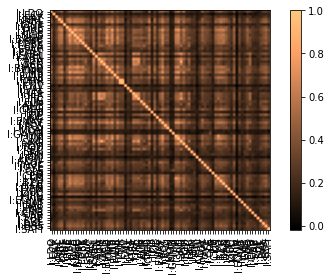

In [14]:
#Layout settings and graph of the correlation matrix
plt.set_cmap("copper")
py.plotting.plot_covariance(rp.covar_matrix(returns.dropna()),plot_correlation=True, show_tickers=True,filename="corr"+x+".png",)

<Axes: >

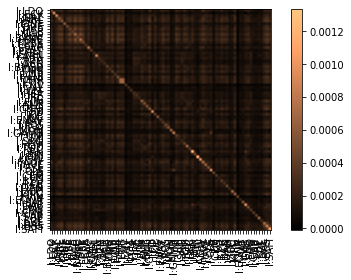

In [15]:
# graph of the variance covariance matrix
py.plotting.plot_covariance((rp.covar_matrix(returns.dropna())), plot_correlation=False,show_tickers=True,filename="cov"+x+".png")

In [16]:
from itertools import combinations


# Get all possible combinations of stock pairs
all_combinations = list(combinations(correlation_matrix.columns, 2))

# Calculate the mean correlation for each stock
mean_correlation = correlation_matrix.mean(axis=1)

# Sort the stocks based on mean correlation in ascending order
sorted_stocks = mean_correlation.sort_values()

# Get the top 12 stocks with the lowest mean correlation
top_12_stocks = sorted_stocks[:12]

print(f"Top 12 stocks with lowest mean correlation: {top_12_stocks}")

Top 12 stocks with lowest mean correlation: I:VIN     0.061264
I:FUL     0.106446
I:ENV     0.117296
I:ECK     0.123312
I:MON     0.128166
I:B       0.136845
I:FD      0.137097
I:GAMB    0.143569
I:BE      0.170550
I:IKG     0.173696
I:RAT     0.176864
I:ZUC     0.182786
dtype: float64


In [17]:
#Saving the sample. From now on, we are always going to work on the following.
tickers=['I:VIN', 'I:FUL', 'I:ENV', 'I:ECK', 'I:MON', 'I:B', 'I:FD', 'I:GAMB', 'I:BE', 'I:IKG', 'I:RAT', 'I:ZUC']
data=data[tickers]
returns=returns[tickers]
returns.head()

,I:VIN,I:FUL,I:ENV,I:ECK,I:MON,I:B,I:FD,I:GAMB,I:BE,I:IKG,I:RAT,I:ZUC
Code,,,,,,,,,,,,
2019-03-06,-0.017241,-0.004819,0.000000,0.0,-0.003077,0.000000,-0.003831,-0.024658,0.003425,-0.001208,-0.005348,-0.014778
2019-03-07,0.000000,-0.009685,0.000000,0.0,0.012346,-0.002203,-0.007692,0.019663,-0.023891,-0.007260,0.005376,0.000000
2019-03-08,-0.008772,0.007335,-0.002857,0.0,0.000000,-0.006623,-0.007752,-0.019284,0.000000,-0.023157,-0.005348,-0.005000
2019-03-11,0.000000,-0.029126,0.017192,0.0,0.000000,-0.002222,0.000000,0.039326,0.003497,0.000000,0.002688,0.000000
2019-03-12,0.000000,0.022500,-0.014085,0.0,0.000000,0.004454,0.011719,-0.016216,-0.017422,-0.011853,0.024129,0.005025


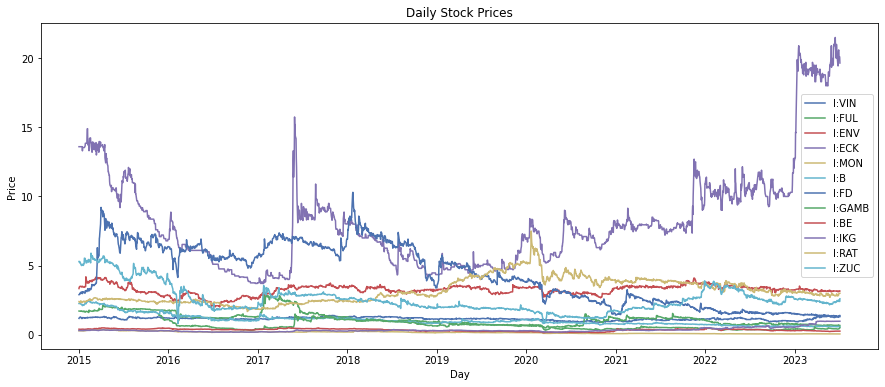

In [18]:
#PLOT OF THE BEHAVIOUR OF EACH STOCK
import matplotlib.pyplot as plt
# Iterate over the stock columns
# Set the figsize
fig, ax = plt.subplots(figsize=(15, 6))

for stock in data:
    # Plot the daily prices for the current stock
    plt.plot(data[stock], label=stock)

# Set the title and labels for the plot
plt.title('Daily Stock Prices')
plt.xlabel('Day')
plt.ylabel('Price')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# FTSE ALL SHARE TOTAL RETURN - STATISTICS

In [19]:
#We firstly computed this statistics, the BETA and the SML in order to get all the useful data for the MVO model.
index=pd.read_excel('C:/Users/gabri/Downloads/exam 2023/exam 2023/data for exam 2023.xlsx',sheet_name=mib_sheet, index_col=0)
index_ret = index.pct_change()
# drop Not Applicable
index_ret=index_ret[~index_ret.isin([np.inf, -np.inf, np.nan]).all(axis='columns')].dropna()
index_ret.tail()

,FTSE ITALIA ALL SHARE - TOT RETURN IND
nan,
2023-07-03,0.006650
2023-07-04,-0.001891
2023-07-05,-0.005559
2023-07-06,-0.024663
2023-07-07,0.009915


In [20]:
#STATISTICS FOR FTSE ITALIA ALL SHARE - TR
ptf_stats(index_ret.squeeze(),r=True)

Mean: 0.00040854278119015013
STD: 0.013781751990240227
Variance: 0.00018993668792049043
Skew: -1.3297688103868006
Kurtosis: 15.181740912769644


In [21]:
# BETA
# define a function for computing beta. SOURCE: Stackoverflow
def beta(df):
    X = df.values[:, [0]]
    X = np.concatenate([np.ones_like(X), X], axis=1)
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values[:, 1:])
    return pd.Series(b[1], df.columns[1:], name='Beta')

In [22]:
## Modify the returns dataframe to include the index
returnsIndex=returns.copy()
returnsIndex['Index']=index_ret
cols = list(returnsIndex.columns)
cols = [cols[-1]] + cols[:-1]
returnsIndex = returnsIndex[cols]
returnsIndex

,Index,I:VIN,I:FUL,I:ENV,I:ECK,I:MON,I:B,I:FD,I:GAMB,I:BE,I:IKG,I:RAT,I:ZUC
Code,,,,,,,,,,,,,
2019-03-06,0.006835,-0.017241,-0.004819,0.000000,0.000000,-0.003077,0.000000,-0.003831,-0.024658,0.003425,-0.001208,-0.005348,-0.014778
2019-03-07,-0.007758,0.000000,-0.009685,0.000000,0.000000,0.012346,-0.002203,-0.007692,0.019663,-0.023891,-0.007260,0.005376,0.000000
2019-03-08,-0.009737,-0.008772,0.007335,-0.002857,0.000000,0.000000,-0.006623,-0.007752,-0.019284,0.000000,-0.023157,-0.005348,-0.005000
2019-03-11,0.005999,0.000000,-0.029126,0.017192,0.000000,0.000000,-0.002222,0.000000,0.039326,0.003497,0.000000,0.002688,0.000000
2019-03-12,0.000056,0.000000,0.022500,-0.014085,0.000000,0.000000,0.004454,0.011719,-0.016216,-0.017422,-0.011853,0.024129,0.005025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-28,0.008562,-0.023256,-0.062857,0.019355,0.053985,0.000000,0.000000,0.041985,0.000000,0.003861,-0.003061,0.000000,0.004149
2023-06-29,0.009680,0.039683,0.000000,0.000000,0.004878,0.000000,0.000000,0.000000,0.014218,0.000000,0.000000,0.031802,0.012397
2023-06-30,0.010570,0.000000,0.051829,0.000000,-0.024272,0.000000,0.000000,0.007326,0.000000,0.000000,-0.004094,0.020548,0.032653


## Beta computation

I:VIN     0.109332
I:FUL     0.448959
I:ENV     0.238373
I:ECK     0.430912
I:MON     0.332359
I:B       0.308885
I:FD      0.463021
I:GAMB    0.443711
I:BE      0.493451
I:IKG     0.472963
I:RAT     0.432929
I:ZUC     0.569741
Name: Beta, dtype: float64

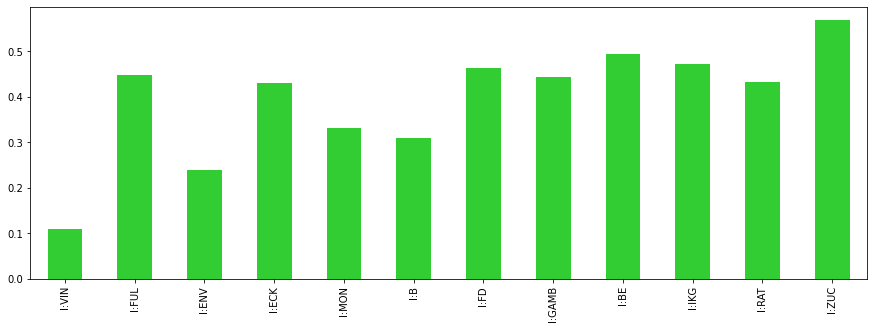

In [23]:
betasample=beta(returnsIndex.dropna())
plt.figure(figsize=(15,5))
betasample.plot.bar(color='#32CD32')
betasample

## Security Market Line - SML

In [24]:
riskfreerate = 0.03
riskmarket=((index_ret.mean()+1)**t_freq-1).squeeze()
# Expected return using the CAPM
expretCAPM=riskfreerate+betasample*(riskmarket-riskfreerate)
expretCAPM

I:VIN     0.038573
I:FUL     0.065205
I:ENV     0.048692
I:ECK     0.063790
I:MON     0.056062
I:B       0.054221
I:FD      0.066308
I:GAMB    0.064794
I:BE      0.068694
I:IKG     0.067088
I:RAT     0.063948
I:ZUC     0.074677
Name: Beta, dtype: float64

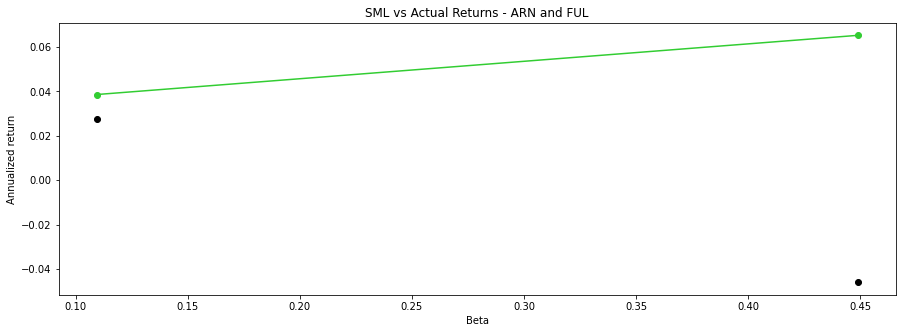

In [25]:
#Historical real returns annualized
real_ret=(1+returnsIndex.iloc[:,1:]).prod()**(t_freq/len(returnsIndex))-1
# Plot the SML - Only two stocks, to check if this and the one below are the same.
plt.figure(figsize=(15,5))
plt.title('SML vs Actual Returns - ARN and FUL')
plt.xlabel('Beta')
plt.ylabel('Annualized return')
plt.plot(betasample.iloc[:2],expretCAPM.iloc[:2],color='#32CD32')
plt.scatter(betasample.iloc[:2],expretCAPM.iloc[:2],color='#32CD32')
plt.scatter(betasample.iloc[:2],real_ret.iloc[:2],color='black')

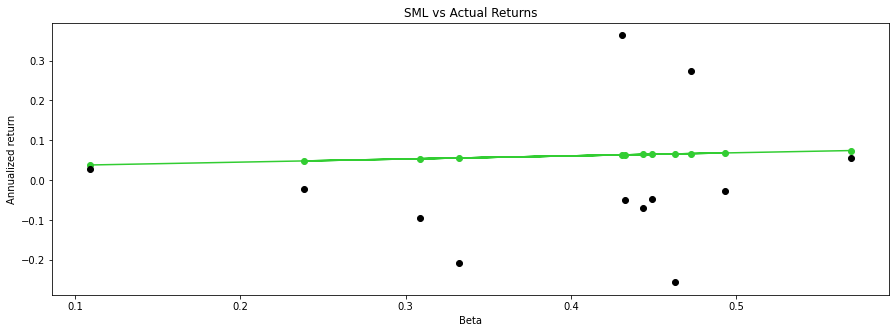

In [26]:
# SML - All sample stocks
plt.figure(figsize=(15,5))
plt.title('SML vs Actual Returns')
plt.xlabel('Beta')
plt.ylabel('Annualized return')
plt.plot(betasample,expretCAPM,color='#32CD32')
plt.scatter(betasample,expretCAPM,color='#32CD32')
plt.scatter(betasample,real_ret,color='black')

# MEAN - VARIANCE OPTIMIZATION

In [27]:
#Covariance matrix estimation 
COVM=(rp.covar_matrix(returns.dropna())+1)**t_freq-1
display(COVM)


,I:VIN,I:FUL,I:ENV,I:ECK,I:MON,I:B,I:FD,I:GAMB,I:BE,I:IKG,I:RAT,I:ZUC
I:VIN,0.110833,0.005474,-0.001639,-0.000383,-0.000485,0.008350,0.004136,0.008049,0.008952,0.013069,0.003927,0.003481
I:FUL,0.005474,0.393640,-0.001031,0.020923,0.013802,0.013923,0.039803,0.007658,0.019130,0.017688,0.022654,0.028219
I:ENV,-0.001639,-0.001031,0.083321,0.004140,0.015075,0.010828,0.013962,0.008546,0.012275,0.007899,0.007707,0.010563
I:ECK,-0.000383,0.020923,0.004140,0.269109,0.005854,0.002476,0.019326,0.006821,0.019756,0.015971,0.014334,0.007442
I:MON,-0.000485,0.013802,0.015075,0.005854,0.177935,0.011766,0.015188,0.023282,0.015326,0.010535,0.020537,0.016902
I:B,0.008350,0.013923,0.010828,0.002476,0.011766,0.116457,0.020870,0.008461,0.011311,0.011216,0.013820,0.017966
I:FD,0.004136,0.039803,0.013962,0.019326,0.015188,0.020870,0.271844,0.015852,0.018323,0.011370,0.031728,0.024397
I:GAMB,0.008049,0.007658,0.008546,0.006821,0.023282,0.008461,0.015852,0.230546,0.013629,0.016397,0.023018,0.029463
I:BE,0.008952,0.019130,0.012275,0.019756,0.015326,0.011311,0.018323,0.013629,0.194992,0.014732,0.024755,0.020853
I:IKG,0.013069,0.017688,0.007899,0.015971,0.010535,0.011216,0.011370,0.016397,0.014732,0.145365,0.018162,0.019321


In [28]:
# function to plot the efficient frontier
def plot_ef(mu,S,ss_bound=0):
    n_samples = 60000
    w = np.random.dirichlet(np.ones(len(mu)), n_samples)
    rets = w.dot(mu)
    stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
    sharpes = rets / stds
    # EFFICIENT FRONTIER
    ef = py.EfficientFrontier(mu, S, weight_bounds=(ss_bound, 1))
    fig, ax = plt.subplots()
    py.plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
    # MAX SHARPE
    ef2 = py.EfficientFrontier(mu, S,weight_bounds=(ss_bound, 1))
    #Important: risk-free-rate is 3%
    ef2.max_sharpe(risk_free_rate=0.03)
    ret_tangent, std_tangent, _ = ef2.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="o",s=60,color='red',label='Max Sharpe Portfolio')
    # FIND MIN VARIANCE PORTFOLIO
    ef3 = py.EfficientFrontier(mu, S,weight_bounds=(ss_bound, 1))
    ef3.min_volatility()
    ret_mr, std_mr, _ = ef3.portfolio_performance()
    ax.scatter(std_mr, ret_mr, marker="*",s=60,color='red', label='MinimumVariance Portfolio')
    # PLOT MONTECARLO SIM.
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis")
    # Format
    ax.legend()
    plt.show()

## Case 1 - Short Selling is Allowed (i.e. negative weights may occur)

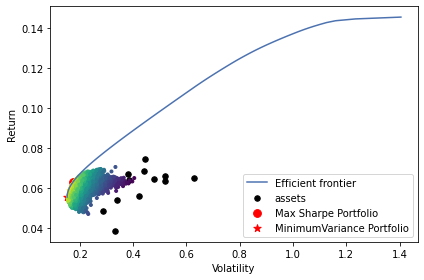

In [30]:
plot_ef(expretCAPM,COVM,ss_bound=None)

In [31]:
#MAX SHARPE with short selling allowed
ef = py.EfficientFrontier(expretCAPM, COVM, weight_bounds=(None, None))
MeanVarPF = pd.Series(ef.max_sharpe())

print(MeanVarPF, "\n","\n", ef.portfolio_performance())


I:VIN     0.067366
I:FUL     0.036292
I:ENV     0.137845
I:ECK     0.072498
I:MON     0.061037
I:B       0.101759
I:FD      0.046668
I:GAMB    0.066655
I:BE      0.088800
I:IKG     0.128600
I:RAT     0.089582
I:ZUC     0.102897
dtype: float64 
 
 (0.06079454028018259, 0.1633360583202105, 0.24975832464505388)


In [32]:
#MIN VARIANCE with short selling allowed
ef = py.EfficientFrontier(expretCAPM, COVM, weight_bounds=(None, None))
GMVMeanVarPF = pd.Series(ef.min_volatility())
print(GMVMeanVarPF, "\n","\n", ef.portfolio_performance())


I:VIN     0.180990
I:FUL     0.029842
I:ENV     0.214476
I:ECK     0.061627
I:MON     0.070206
I:B       0.117664
I:FD      0.027780
I:GAMB    0.048447
I:BE      0.049536
I:IKG     0.079256
I:RAT     0.071836
I:ZUC     0.048340
dtype: float64 
 
 (0.05552229947276891, 0.15241635971651843, 0.23306093610185544)


In [33]:
ptf_stats(MeanVarPF)

Mean: 0.00033197143680691857
STD: 0.010041318977232339
Variance: 0.0001008280868025263
Skew: -1.3359670893377356
Kurtosis: 12.40547812933244


In [34]:
ptf_stats(GMVMeanVarPF)

Mean: 0.00025257113615292654
STD: 0.009392753503276367
Variance: 8.822381837331047e-05
Skew: -0.9791559223156894
Kurtosis: 8.882172180732415


## Case 2 - Short Selling is NOT allowed (i.e. only positive value and smaller than 1)

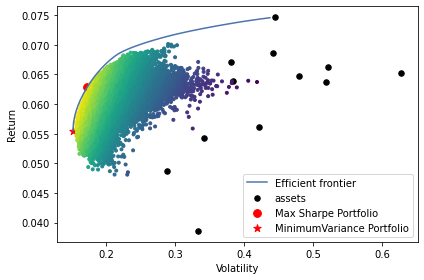

In [36]:
plot_ef(expretCAPM,COVM,ss_bound=0)

In [37]:
#max SHARPE PF with short selling NOT ALLOWED
ef = py.EfficientFrontier(expretCAPM, COVM, weight_bounds=(0, 1))
MeanVarSSNAPF=pd.Series(ef.max_sharpe())
print(MeanVarSSNAPF, "\n","\n", ef.portfolio_performance())

I:VIN     0.067366
I:FUL     0.036292
I:ENV     0.137845
I:ECK     0.072498
I:MON     0.061037
I:B       0.101759
I:FD      0.046668
I:GAMB    0.066655
I:BE      0.088800
I:IKG     0.128600
I:RAT     0.089582
I:ZUC     0.102897
dtype: float64 
 
 (0.06079454028018259, 0.1633360583202105, 0.24975832464505388)


In [38]:
ptf_stats(MeanVarSSNAPF)

Mean: 0.00033197143680691857
STD: 0.010041318977232339
Variance: 0.0001008280868025263
Skew: -1.3359670893377356
Kurtosis: 12.40547812933244


In [39]:
#GMV portofolio with short selling NOT ALLOWED
ef = py.EfficientFrontier(expretCAPM, COVM, weight_bounds=(0, 1))
MeanVARGMVPFSSNA= pd.Series(ef.min_volatility())
print(MeanVARGMVPFSSNA, "\n","\n", ef.portfolio_performance())


I:VIN     0.180990
I:FUL     0.029842
I:ENV     0.214476
I:ECK     0.061627
I:MON     0.070206
I:B       0.117664
I:FD      0.027780
I:GAMB    0.048447
I:BE      0.049536
I:IKG     0.079256
I:RAT     0.071836
I:ZUC     0.048340
dtype: float64 
 
 (0.05552229947276891, 0.15241635971651843, 0.23306093610185544)


In [40]:
ptf_stats(MeanVARGMVPFSSNA)



Mean: 0.00025257113615292654
STD: 0.009392753503276367
Variance: 8.822381837331047e-05
Skew: -0.9791559223156894
Kurtosis: 8.882172180732415


In [41]:
#We have now calculated all the weights in order to compute the Beta of the portfolio.
Betapf = sum(MeanVarPF *betasample)
Betapf

0.39270854071590483

# BLACK LITTERMAN 

### Priors 

In [42]:
COVM = (rp.covar_matrix(returns.dropna())+1)**t_freq-1

<Axes: >

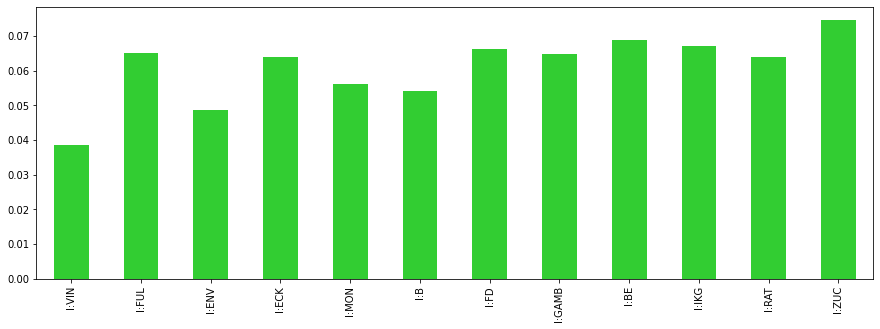

In [43]:
# We can't use the market cap, so we set the market prior equal to the Expected Return obtained from CAPM
market_prior=expretCAPM
market_prior.plot.bar(color='#32CD32',figsize=(15,5))

In [44]:
#This is the code that allow us to implement our views and create the P matrix.
#Source: https://nbviewer.org/github/dcajasn/Riskfolio-Lib/blob/master/examples/Tutorial%203%20-%20Black%20Litterman%20Mean%20Risk%20Optimization.ipynb
asset_classes = {'Assets': tickers,
                 'Section': ['Same','Good','Same','Good1','Bad','Same','Same','Same','Same','Same','Same','Bad1']}
asset_classes = pd.DataFrame(asset_classes)

views = {'Disabled': [False, False, False, False],
         'Type': ['Classes', 'Classes', 'Assets', 'Assets'],
         'Set': ['Section', 'Section', '', ''],
         'Position': ['Good', 'Good1', 'I:VIN','I:ECK'],
         'Sign': ['>=', '>=', '<=', '='],
         'Weight': [0.02, 0.02, -0.05, 0.05],
         'Type Relative': ['Classes', 'Classes', '', ''],
         'Relative Set': ['Section', 'Section', '', ''],
         'Relative': ['Bad', 'Bad1', '', '']}

views = pd.DataFrame(views)
display(views)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative
0,False,Classes,Section,Good,>=,0.02,Classes,Section,Bad
1,False,Classes,Section,Good1,>=,0.02,Classes,Section,Bad1
2,False,Assets,,I:VIN,<=,-0.05,,,
3,False,Assets,,I:ECK,=,0.05,,,


In [45]:
P, Q = rp.assets_views(views, asset_classes)
display(pd.DataFrame(P))
display(pd.DataFrame(Q))


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


,0
0,0.02
1,0.02
2,0.05
3,0.05


In [46]:
# To estimate the error of our views we use the Idzorek Approach
confidences=[0.2,0.15,0.6,0.5]
blacklit = py.BlackLittermanModel(COVM, pi=market_prior, Q=Q,P=P, omega="idzorek",view_confidences=confidences, tau=0.05)
pd.DataFrame(blacklit.omega)


,0,1,2,3
0,0.108794,0.000000,0.000000,0.000000
1,0.000000,0.127923,0.000000,0.000000
2,0.000000,0.000000,0.003694,0.000000
3,0.000000,0.000000,0.000000,0.013455


<Axes: >

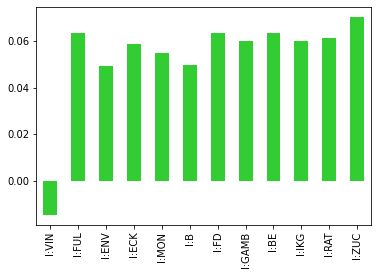

In [47]:
# POSTERIOR Expected Returns
posterior_ret=blacklit.bl_returns()
posterior_ret.plot.bar(color='#32CD32')

In [48]:
# POSTERIOR variance/covariance matrix
posterior_covariance=blacklit.bl_cov()
print(pd.DataFrame(posterior_covariance))


           I:VIN     I:FUL     I:ENV     I:ECK     I:MON       I:B      I:FD  \
I:VIN   0.113050  0.005566 -0.001672 -0.000384 -0.000488  0.008516  0.004217   
I:FUL   0.005566  0.410626 -0.000978  0.021432  0.015622  0.014585  0.041579   
I:ENV  -0.001672 -0.000978  0.087479  0.004265  0.015775  0.011370  0.014659   
I:ECK  -0.000384  0.021432  0.004265  0.275539  0.006055  0.002576  0.019838   
I:MON  -0.000488  0.015622  0.015775  0.006055  0.186329  0.012355  0.016006   
I:B     0.008516  0.014585  0.011370  0.002576  0.012355  0.122256  0.021895   
I:FD    0.004217  0.041579  0.014659  0.019838  0.016006  0.021895  0.285382   
I:GAMB  0.008210  0.008120  0.008965  0.007053  0.024388  0.008857  0.016624   
I:BE    0.009131  0.020011  0.012885  0.020274  0.016089  0.011849  0.019190   
I:IKG   0.013330  0.018475  0.008294  0.016395  0.011071  0.011741  0.011890   
I:RAT   0.004005  0.023737  0.008087  0.014724  0.021558  0.014495  0.033280   
I:ZUC   0.003546  0.029478  0.011065  0.

In [49]:
#  IMPLIED WEIGHTS
pd.DataFrame(blacklit.bl_weights(), index=blacklit.bl_weights().keys()).iloc[[0]].T

,I:VIN
I:VIN,-0.117461
I:FUL,0.045991
I:ENV,0.210513
I:ECK,0.076763
I:MON,0.079094
I:B,0.136765
I:FD,0.050722
I:GAMB,0.076465
I:BE,0.094991
I:IKG,0.141011


In [50]:
blacklit.portfolio_performance()


(0.06661362221555472, 0.19266735162260767, 0.24193835552823914)

## CASE 1 - Black Litterman with Short Selling allowed 

In [51]:
ef = py.EfficientFrontier(posterior_ret, posterior_covariance,weight_bounds =(None,None))
BlackLitPF = pd.Series(ef.max_sharpe())
print(BlackLitPF, "\n", "\n", ef.portfolio_performance())

I:VIN    -0.381055
I:FUL     0.060128
I:ENV     0.208273
I:ECK     0.093238
I:MON     0.086929
I:B       0.153749
I:FD      0.070512
I:GAMB    0.100711
I:BE      0.134170
I:IKG     0.194305
I:RAT     0.135351
I:ZUC     0.143688
dtype: float64 
 
 (0.08687417364834318, 0.2634060958654705, 0.25388240704382886)


In [52]:
ef = py.EfficientFrontier(posterior_ret, posterior_covariance, weight_bounds =(None,None))
BlackLitGMVPF = pd.Series(ef.min_volatility())
print(BlackLitGMVPF, "\n", "\n", ef.portfolio_performance())

I:VIN     0.185605
I:FUL     0.029570
I:ENV     0.212698
I:ECK     0.063117
I:MON     0.069648
I:B       0.116689
I:FD      0.027549
I:GAMB    0.048046
I:BE      0.049126
I:IKG     0.078599
I:RAT     0.071240
I:ZUC     0.048113
dtype: float64 
 
 (0.04331544290105853, 0.1555315291757005, 0.14990814418547632)


## CASE 2 - Black Litterman with Short Selling NOT allowed 

In [53]:
ef = py.EfficientFrontier(posterior_ret, posterior_covariance,weight_bounds =(0,1))
BlackLitSSNA = pd.Series(ef.max_sharpe())
print(BlackLitSSNA, "\n", "\n", ef.portfolio_performance())

I:VIN     0.000000
I:FUL     0.043706
I:ENV     0.168895
I:ECK     0.073325
I:MON     0.070102
I:B       0.098779
I:FD      0.051719
I:GAMB    0.068417
I:BE      0.090775
I:IKG     0.124002
I:RAT     0.101187
I:ZUC     0.109094
dtype: float64 
 
 (0.05880116186884893, 0.1743771007852021, 0.2225129428929102)


In [54]:
ef = py.EfficientFrontier(posterior_ret, posterior_covariance,weight_bounds =(0,1))
BlackLitGMVssna = pd.Series(ef.min_volatility())
print(BlackLitGMVssna, "\n", "\n", ef.portfolio_performance())


I:VIN     0.185605
I:FUL     0.029570
I:ENV     0.212698
I:ECK     0.063117
I:MON     0.069648
I:B       0.116689
I:FD      0.027549
I:GAMB    0.048046
I:BE      0.049126
I:IKG     0.078599
I:RAT     0.071240
I:ZUC     0.048113
dtype: float64 
 
 (0.04331544290105853, 0.1555315291757005, 0.14990814418547632)


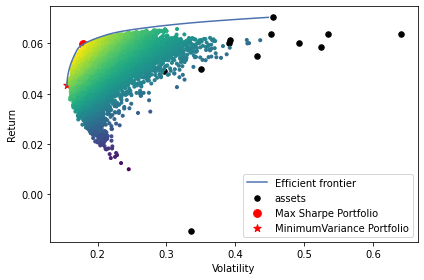

In [59]:
#Plot of the efficient frontier in the short selling case

plot_ef(posterior_ret,posterior_covariance)


In [56]:
ptf_stats(BlackLitPF)

Mean: 0.000320790020239005
STD: 0.015818814839929873
Variance: 0.00025023490293998553
Skew: -0.6891584710179913
Kurtosis: 6.84262372237554


In [57]:
ptf_stats(BlackLitGMVssna)

Mean: 0.0002558480628121487
STD: 0.009392563906728381
Variance: 8.82202567419767e-05
Skew: -0.9690397159909481
Kurtosis: 8.75193357866109


# BAYESIAN  Approach

In [60]:
T=len(returns)
# Estimation of the sample parameters
mu_sample=np.array((1+returns).prod()**(t_freq/len(returns))-1)
sigma_sample=np.array((1+returns.cov()))**(t_freq)-1

# Estimation of the conjugate priors parameters
mu_0=mu_sample+(1+returns.std())**(t_freq/len(returns))-1
lambda_0=sigma_sample*2

# Estimaion of the posterior density parameters
mu_1=np.linalg.inv(T*np.linalg.inv(sigma_sample)+np.linalg.inv(lambda_0))@(T*np.linalg.inv(sigma_sample)@ mu_sample.T +np.linalg.inv(lambda_0)@mu_0)
sigma_1=np.linalg.inv(T*np.linalg.inv(sigma_sample)+np.linalg.inv(lambda_0))
# predictive density covariance matrix and weights
sigma_prior=sigma_1+sigma_sample

In [61]:
Sigma_bayesian=pd.DataFrame(sigma_prior,index=tickers,columns=tickers)
mu_bayesian=pd.Series(mu_1,index=tickers)


In [62]:
ef = py.EfficientFrontier(mu_bayesian, Sigma_bayesian,weight_bounds =(0,1))
PFBayesian=pd.Series(ef.min_volatility())
print(PFBayesian)

I:VIN     0.180990
I:FUL     0.029842
I:ENV     0.214476
I:ECK     0.061627
I:MON     0.070206
I:B       0.117664
I:FD      0.027780
I:GAMB    0.048447
I:BE      0.049536
I:IKG     0.079256
I:RAT     0.071836
I:ZUC     0.048340
dtype: float64


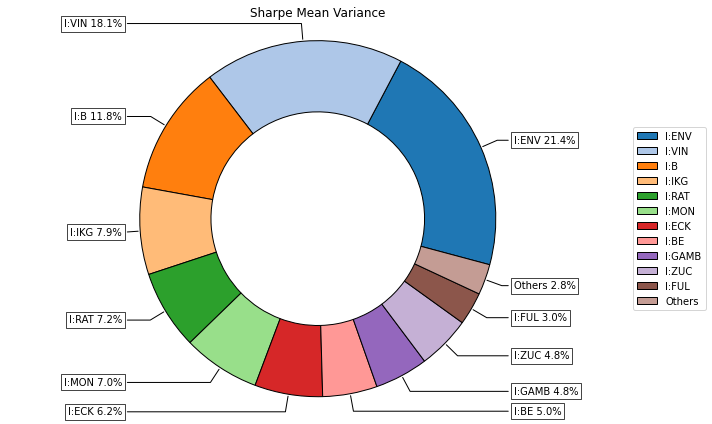

In [63]:
BayesianPF = pd.DataFrame(PFBayesian)
WBayesian = rp.plot_pie(BayesianPF, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

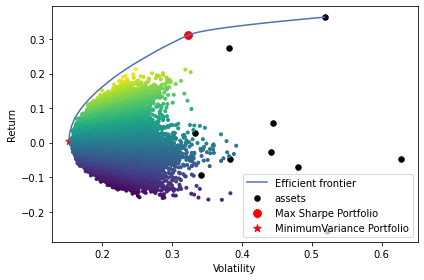

In [67]:
plot_ef(mu_bayesian, Sigma_bayesian)

In [65]:
 ptf_stats(PFBayesian)

Mean: 0.00025257113615292654
STD: 0.009392753503276369
Variance: 8.82238183733105e-05
Skew: -0.9791559223156897
Kurtosis: 8.882172180732423


# Portfolio Mix

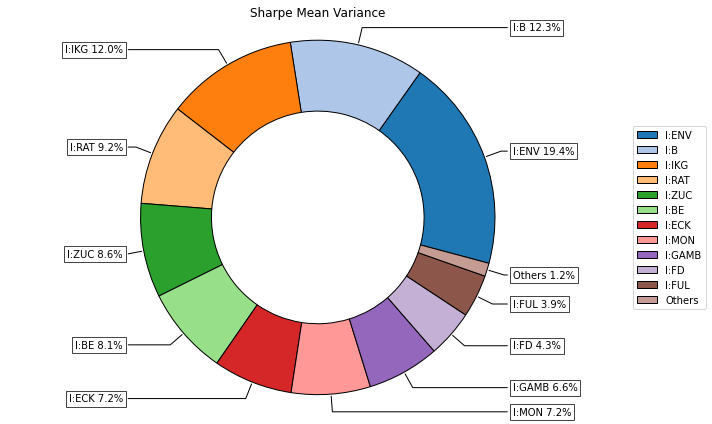

In [68]:
portfolio_ew = 0.25 * GMVMeanVarPF + 0.25 * PFBayesian + 0.25 * BlackLitPF + 0.25* MeanVarPF
pf_ew =pd.DataFrame(portfolio_ew)
ax = rp.plot_pie(pf_ew, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [69]:
ptf_stats(portfolio_ew)


Mean: 0.00028947593233794413
STD: 0.010194135103472895
Variance: 0.00010392039050785834
Skew: -1.2391711268270469
Kurtosis: 11.888405139653068
